In [1]:
import tensorflow as tf
import autokeras as ak

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[-1], 'GPU')

### Load california dataset

In [3]:
from sklearn.datasets import fetch_california_housing

house_dataset = fetch_california_housing()

# Import pandas package to format the data
import pandas as pd

# Extract features with their names into the a dataframe format
data = pd.DataFrame(house_dataset.data, columns=house_dataset.feature_names)

# Extract target with their names into a pd.Series object with name MEDV
target = pd.Series(house_dataset.target, name = 'MEDV')

from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, target, test_size=0.2, random_state=42)

In [5]:
# Check the shape of whole dataset and the splited training and test set
print("--Shape of the whole data--\n {}".format(data.shape))
print("\n--Shape of the target vector--\n {}".format(target.shape))
print("\n--Shape of the training data--\n {}".format(train_data.shape))
print("\n--Shape of the testing data--\n {}".format(test_data.shape))

--Shape of the whole data--
 (20640, 8)

--Shape of the target vector--
 (20640,)

--Shape of the training data--
 (16512, 8)

--Shape of the testing data--
 (4128, 8)


### Tuning MLP for structured-data regression  (Normalization + DenseBlock)

In [10]:
input_node = ak.StructuredDataInput()
# output_node = ak.CategoricalToNumerical()(input_node)
output_node = input_node
output_node = ak.Normalization()(input_node)
output_node = ak.DenseBlock(use_batchnorm=False, dropout=0.0)(output_node)
output_node = ak.RegressionHead(dropout=0.0)(output_node)
auto_model = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=10, overwrite=True, seed=42)

auto_model.fit(train_data, train_targets, batch_size=1024, epochs=150)


Trial 10 Complete [00h 00m 51s]
val_loss: 0.29150065779685974

Best val_loss So Far: 0.2891707420349121
Total elapsed time: 00h 07m 31s
INFO:tensorflow:Oracle triggered exit
Epoch 1/150
17/17 [==============================] - 0s 13ms/step - loss: 3.1265 - mean_squared_error: 3.1265
Epoch 2/150
17/17 [==============================] - 0s 13ms/step - loss: 1.2345 - mean_squared_error: 1.2345
Epoch 3/150
17/17 [==============================] - 0s 11ms/step - loss: 0.8682 - mean_squared_error: 0.8682
Epoch 4/150
17/17 [==============================] - 0s 12ms/step - loss: 0.7673 - mean_squared_error: 0.7673
Epoch 5/150
17/17 [==============================] - 0s 14ms/step - loss: 0.6840 - mean_squared_error: 0.6840
Epoch 6/150
17/17 [==============================] - 0s 13ms/step - loss: 0.6084 - mean_squared_error: 0.6084
Epoch 7/150
17/17 [==============================] - 0s 13ms/step - loss: 0.5405 - mean_squared_error: 0.5405
Epoch 8/150
17/17 [==============================] - 0s 

17/17 [==============================] - 0s 14ms/step - loss: 0.2493 - mean_squared_error: 0.2493
Epoch 147/150
17/17 [==============================] - 0s 15ms/step - loss: 0.2479 - mean_squared_error: 0.2479
Epoch 148/150
17/17 [==============================] - 0s 14ms/step - loss: 0.2486 - mean_squared_error: 0.2486
Epoch 149/150
17/17 [==============================] - 0s 13ms/step - loss: 0.2471 - mean_squared_error: 0.2471
Epoch 150/150
17/17 [==============================] - 0s 13ms/step - loss: 0.2475 - mean_squared_error: 0.2475
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


### Visualize the best pipeline

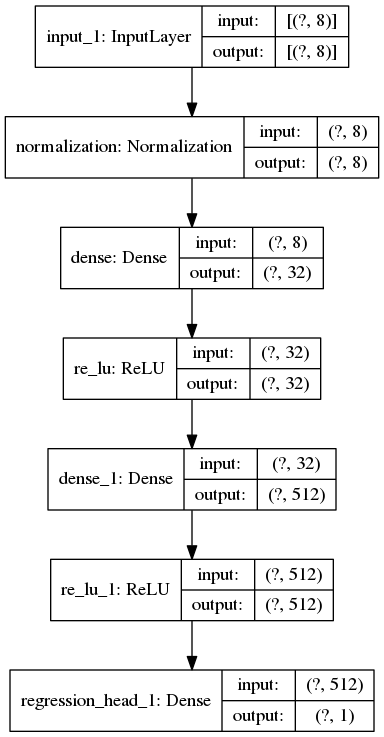

In [16]:
best_model = auto_model.export_model()
tf.keras.utils.plot_model(best_model, show_shapes=True, expand_nested=True) # rankdir='LR'

### Evaluate best pipeline

In [17]:
test_loss, test_acc = auto_model.evaluate(test_data, test_targets, verbose=0)
print('Test accuracy: ', test_acc)

Test accuracy:  0.2801434397697449


### Show best trial

In [18]:
auto_model.tuner.results_summary(num_trials=1)

Results summary
Results in ./auto_model
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
dense_block_1/num_layers: 2
dense_block_1/units_0: 32
dense_block_1/dropout: 0.0
dense_block_1/units_1: 512
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.001
Score: 0.2891707420349121


In [19]:
best_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense (Dense)                (None, 32)                288       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16896     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)               0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 1)                

### Customize the search space for tuning MLP

In [6]:
from kerastuner.engine import hyperparameters as hp

input_node = ak.StructuredDataInput()
# output_node = ak.CategoricalToNumerical()(input_node)
output_node = ak.Normalization()(input_node)
output_node = ak.DenseBlock(num_layers=1, 
                            num_units=hp.Choice("num_units", [128, 256, 512, 1024]),
                            use_batchnorm=False, 
                            dropout=0.0)(output_node)
output_node = ak.DenseBlock(num_layers=1, 
                            num_units=hp.Choice("num_units", [16, 32, 64]),
                            use_batchnorm=False, 
                            dropout=0.0)(output_node)
output_node = ak.RegressionHead()(output_node)
auto_model = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=10, overwrite=True, seed=42)

auto_model.fit(train_data, train_targets, batch_size=1024, epochs=150)


Trial 10 Complete [00h 00m 50s]
val_loss: 0.9883975982666016

Best val_loss So Far: 0.28371483087539673
Total elapsed time: 00h 07m 47s
INFO:tensorflow:Oracle triggered exit
Epoch 1/150
17/17 [==============================] - 0s 13ms/step - loss: 3.3178 - mean_squared_error: 3.3178
Epoch 2/150
17/17 [==============================] - 0s 14ms/step - loss: 1.1573 - mean_squared_error: 1.1573
Epoch 3/150
17/17 [==============================] - 0s 13ms/step - loss: 0.8219 - mean_squared_error: 0.8219
Epoch 4/150
17/17 [==============================] - 0s 12ms/step - loss: 0.7146 - mean_squared_error: 0.7146
Epoch 5/150
17/17 [==============================] - 0s 13ms/step - loss: 0.6382 - mean_squared_error: 0.6382
Epoch 6/150
17/17 [==============================] - 0s 13ms/step - loss: 0.5758 - mean_squared_error: 0.5758
Epoch 7/150
17/17 [==============================] - 0s 13ms/step - loss: 0.5263 - mean_squared_error: 0.5263
Epoch 8/150
17/17 [==============================] - 0s 

17/17 [==============================] - 0s 9ms/step - loss: 0.2426 - mean_squared_error: 0.2426
Epoch 147/150
17/17 [==============================] - 0s 12ms/step - loss: 0.2414 - mean_squared_error: 0.2414
Epoch 148/150
17/17 [==============================] - 0s 13ms/step - loss: 0.2415 - mean_squared_error: 0.2415
Epoch 149/150
17/17 [==============================] - 0s 13ms/step - loss: 0.2407 - mean_squared_error: 0.2407
Epoch 150/150
17/17 [==============================] - 0s 9ms/step - loss: 0.2407 - mean_squared_error: 0.2407
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


### Display the best pipeline

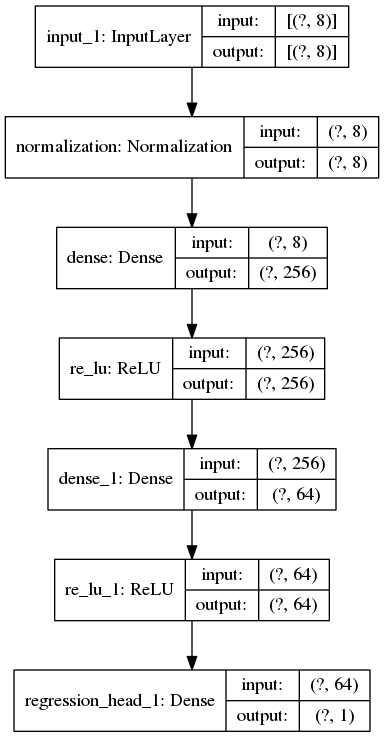

In [7]:
best_model = auto_model.export_model()
tf.keras.utils.plot_model(best_model, show_shapes=True, expand_nested=True) # rankdir='LR'

In [8]:
test_loss, test_acc = auto_model.evaluate(test_data, test_targets, verbose=0)
print('Test accuracy: ', test_acc)

Test accuracy:  0.2712092995643616


In [57]:
auto_model.tuner.results_summary(num_trials=1)

Results summary
Results in ./auto_model
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
dense_block_1/num_layers: 1
dense_block_1/units_0: 256
dense_block_1/dropout: 0.0
dense_block_2/num_layers: 1
dense_block_2/units_0: 64
dense_block_2/dropout: 0.0
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.001
Score: 0.2864270806312561


In [9]:
best_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64)                0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 1)                

## Reference
[ImageClassifier](/image_classifier),
[AutoModel](/auto_model/#automodel-class),
[ImageBlock](/block/#imageblock-class),
[Normalization](/preprocessor/#normalization-class),
[ImageAugmentation](/preprocessor/#image-augmentation-class),
[ResNetBlock](/block/#resnetblock-class),
[ImageInput](/node/#imageinput-class),
[ClassificationHead](/head/#classificationhead-class).